In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = -0.3
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-1.19210443 -0.49761854 -0.1       ]


In [14]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [18]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))
    
    if i%11 == 1:
        return(ms_gate_global_1(theta))
    

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    

    if i%11 == 1:
        return(-1j*matrix_part_1)
    

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [19]:
coeff = 11

In [20]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)
    A = []
    B = []
    for k in range(coeff*N):
        A.append(S(k)@R(k,theta[k]))
        B.append(R(k,theta[k]))
        
    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)
    AA = np.einsum("ijk,il->iljk",A,ID)
    BB = np.einsum("ijk,il->iljk",B,ID)
    DD = CC-BB+AA
    dd = []
    for i in range(coeff*N):
        dd.append(reduce(np.dot,DD[i]))
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)
    
    BBB = reduce(np.dot,B)

    DD_d = np.einsum("kij->kji",DD.conj())
    X = np.einsum("m,imn,jnl,l->ij",np.conj(psi_0),DD_d,DD,psi_0)
    Y = np.einsum("m,imn,nl,lk,k->i",np.conj(psi_0),DD_d,full_ham_matrix.toarray(),BBB,psi_0)
    XX = np.einsum("m,imn,nk,k->i",np.conj(psi_0),DD_d,BBB,psi_0)
    YY_1 = np.einsum("m,mn,ink,k->i",np.conj(psi_0),BBB.conj().T,DD,psi_0)
    YY_2 = np.einsum("m,mn,nk,kl,l",np.conj(psi_0),BBB.conj().T,full_ham_matrix.toarray(),BBB,psi_0 )
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    #v = 1e-6*np.exp(-0)*np.ones(coeff*N)
    #v = np.zeros(coeff*N)
    #X = X + np.diag(v)
    print(t)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.imag(Y+YY)

    return np.linalg.pinv(X_r,rcond = 1e-6)@Y_i

In [21]:
stepp = 3000

In [22]:
time_domain = np.linspace(0, 10, stepp)
Y = []

In [23]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [24]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
import datetime
print(datetime.datetime.now())
rk4(0,0.001*np.ones(coeff*N),10,stepp)
print(datetime.datetime.now())

2022-06-24 18:26:57.627919
0
0.0016666666666666668
0.0016666666666666668
0.0033333333333333335
0.0033333333333333335
0.005
0.005
0.006666666666666667
0.006666666666666667
0.008333333333333333
0.008333333333333333
0.01
0.01
0.011666666666666667
0.011666666666666667
0.013333333333333334
0.013333333333333334
0.015000000000000001
0.015000000000000001
0.016666666666666666
0.016666666666666666
0.018333333333333333
0.018333333333333333
0.02
0.02
0.021666666666666667
0.021666666666666667
0.023333333333333334
0.023333333333333334
0.025
0.025
0.02666666666666667
0.02666666666666667
0.028333333333333335
0.028333333333333335
0.030000000000000002
0.030000000000000002
0.03166666666666667
0.03166666666666667
0.03333333333333333
0.03333333333333333
0.034999999999999996
0.034999999999999996
0.03666666666666667
0.03666666666666667
0.03833333333333333
0.03833333333333333
0.04
0.04
0.041666666666666664
0.041666666666666664
0.043333333333333335
0.043333333333333335
0.045
0.045
0.04666666666666667
0.0466666

0.35833333333333367
0.3600000000000004
0.3600000000000004
0.361666666666667
0.361666666666667
0.36333333333333373
0.36333333333333373
0.3650000000000004
0.3650000000000004
0.3666666666666671
0.3666666666666671
0.36833333333333373
0.36833333333333373
0.37000000000000044
0.37000000000000044
0.3716666666666671
0.3716666666666671
0.3733333333333338
0.3733333333333338
0.37500000000000044
0.37500000000000044
0.37666666666666715
0.37666666666666715
0.3783333333333338
0.3783333333333338
0.3800000000000005
0.3800000000000005
0.38166666666666715
0.38166666666666715
0.38333333333333386
0.38333333333333386
0.3850000000000005
0.3850000000000005
0.3866666666666672
0.3866666666666672
0.38833333333333386
0.38833333333333386
0.39000000000000057
0.39000000000000057
0.3916666666666672
0.3916666666666672
0.3933333333333339
0.3933333333333339
0.3950000000000006
0.3950000000000006
0.3966666666666673
0.3966666666666673
0.3983333333333339
0.3983333333333339
0.40000000000000063
0.40000000000000063
0.4016666666

0.7183333333333324
0.719999999999999
0.719999999999999
0.7216666666666657
0.7216666666666657
0.7233333333333323
0.7233333333333323
0.724999999999999
0.724999999999999
0.7266666666666656
0.7266666666666656
0.7283333333333323
0.7283333333333323
0.7299999999999989
0.7299999999999989
0.7316666666666656
0.7316666666666656
0.7333333333333322
0.7333333333333322
0.7349999999999989
0.7349999999999989
0.7366666666666655
0.7366666666666655
0.7383333333333322
0.7383333333333322
0.7399999999999988
0.7399999999999988
0.7416666666666655
0.7416666666666655
0.7433333333333321
0.7433333333333321
0.7449999999999988
0.7449999999999988
0.7466666666666654
0.7466666666666654
0.7483333333333321
0.7483333333333321
0.7499999999999987
0.7499999999999987
0.7516666666666654
0.7516666666666654
0.753333333333332
0.753333333333332
0.7549999999999987
0.7549999999999987
0.7566666666666653
0.7566666666666653
0.758333333333332
0.758333333333332
0.7599999999999986
0.7599999999999986
0.7616666666666653
0.7616666666666653
0

1.0816666666666646
1.0816666666666646
1.0833333333333313
1.0833333333333313
1.084999999999998
1.084999999999998
1.0866666666666647
1.0866666666666647
1.0883333333333314
1.0883333333333314
1.089999999999998
1.089999999999998
1.0916666666666648
1.0916666666666648
1.0933333333333315
1.0933333333333315
1.0949999999999982
1.0949999999999982
1.096666666666665
1.096666666666665
1.0983333333333316
1.0983333333333316
1.0999999999999983
1.0999999999999983
1.101666666666665
1.101666666666665
1.1033333333333317
1.1033333333333317
1.1049999999999984
1.1049999999999984
1.1066666666666651
1.1066666666666651
1.1083333333333318
1.1083333333333318
1.1099999999999985
1.1099999999999985
1.1116666666666652
1.1116666666666652
1.113333333333332
1.113333333333332
1.1149999999999987
1.1149999999999987
1.1166666666666654
1.1166666666666654
1.118333333333332
1.118333333333332
1.1199999999999988
1.1199999999999988
1.1216666666666655
1.1216666666666655
1.1233333333333322
1.1233333333333322
1.124999999999999
1.1249

1.4483333333333397
1.4483333333333397
1.4500000000000064
1.4500000000000064
1.451666666666673
1.451666666666673
1.4533333333333398
1.4533333333333398
1.4550000000000065
1.4550000000000065
1.4566666666666732
1.4566666666666732
1.45833333333334
1.45833333333334
1.4600000000000066
1.4600000000000066
1.4616666666666733
1.4616666666666733
1.46333333333334
1.46333333333334
1.4650000000000067
1.4650000000000067
1.4666666666666734
1.4666666666666734
1.4683333333333402
1.4683333333333402
1.4700000000000069
1.4700000000000069
1.4716666666666736
1.4716666666666736
1.4733333333333403
1.4733333333333403
1.475000000000007
1.475000000000007
1.4766666666666737
1.4766666666666737
1.4783333333333404
1.4783333333333404
1.480000000000007
1.480000000000007
1.4816666666666738
1.4816666666666738
1.4833333333333405
1.4833333333333405
1.4850000000000072
1.4850000000000072
1.486666666666674
1.486666666666674
1.4883333333333406
1.4883333333333406
1.4900000000000073
1.4900000000000073
1.491666666666674
1.49166666

1.8116666666666814
1.8133333333333481
1.8133333333333481
1.8150000000000148
1.8150000000000148
1.8166666666666815
1.8166666666666815
1.8183333333333482
1.8183333333333482
1.820000000000015
1.820000000000015
1.8216666666666816
1.8216666666666816
1.8233333333333483
1.8233333333333483
1.825000000000015
1.825000000000015
1.8266666666666818
1.8266666666666818
1.8283333333333485
1.8283333333333485
1.8300000000000152
1.8300000000000152
1.8316666666666819
1.8316666666666819
1.8333333333333486
1.8333333333333486
1.8350000000000153
1.8350000000000153
1.836666666666682
1.836666666666682
1.8383333333333487
1.8383333333333487
1.8400000000000154
1.8400000000000154
1.841666666666682
1.841666666666682
1.8433333333333488
1.8433333333333488
1.8450000000000155
1.8450000000000155
1.8466666666666822
1.8466666666666822
1.848333333333349
1.848333333333349
1.8500000000000156
1.8500000000000156
1.8516666666666823
1.8516666666666823
1.853333333333349
1.853333333333349
1.8550000000000157
1.8550000000000157
1.856

2.1783333333333563
2.1800000000000233
2.1800000000000233
2.1816666666666897
2.1816666666666897
2.1833333333333567
2.1833333333333567
2.185000000000023
2.185000000000023
2.18666666666669
2.18666666666669
2.1883333333333566
2.1883333333333566
2.1900000000000235
2.1900000000000235
2.19166666666669
2.19166666666669
2.193333333333357
2.193333333333357
2.1950000000000234
2.1950000000000234
2.1966666666666903
2.1966666666666903
2.198333333333357
2.198333333333357
2.2000000000000237
2.2000000000000237
2.20166666666669
2.20166666666669
2.203333333333357
2.203333333333357
2.2050000000000236
2.2050000000000236
2.2066666666666905
2.2066666666666905
2.208333333333357
2.208333333333357
2.210000000000024
2.210000000000024
2.2116666666666904
2.2116666666666904
2.2133333333333574
2.2133333333333574
2.215000000000024
2.215000000000024
2.2166666666666908
2.2166666666666908
2.2183333333333572
2.2183333333333572
2.220000000000024
2.220000000000024
2.2216666666666907
2.2216666666666907
2.2233333333333576
2.

2.548333333333365
2.548333333333365
2.550000000000032
2.550000000000032
2.5516666666666983
2.5516666666666983
2.553333333333365
2.553333333333365
2.5550000000000317
2.5550000000000317
2.5566666666666986
2.5566666666666986
2.558333333333365
2.558333333333365
2.560000000000032
2.560000000000032
2.5616666666666985
2.5616666666666985
2.5633333333333654
2.5633333333333654
2.565000000000032
2.565000000000032
2.566666666666699
2.566666666666699
2.5683333333333653
2.5683333333333653
2.5700000000000323
2.5700000000000323
2.5716666666666987
2.5716666666666987
2.5733333333333657
2.5733333333333657
2.575000000000032
2.575000000000032
2.576666666666699
2.576666666666699
2.5783333333333656
2.5783333333333656
2.5800000000000325
2.5800000000000325
2.581666666666699
2.581666666666699
2.583333333333366
2.583333333333366
2.5850000000000324
2.5850000000000324
2.5866666666666993
2.5866666666666993
2.588333333333366
2.588333333333366
2.5900000000000327
2.5900000000000327
2.591666666666699
2.591666666666699


2.916666666666707
2.9183333333333734
2.9183333333333734
2.9200000000000403
2.9200000000000403
2.921666666666707
2.921666666666707
2.9233333333333738
2.9233333333333738
2.9250000000000402
2.9250000000000402
2.926666666666707
2.926666666666707
2.9283333333333736
2.9283333333333736
2.9300000000000406
2.9300000000000406
2.931666666666707
2.931666666666707
2.933333333333374
2.933333333333374
2.9350000000000405
2.9350000000000405
2.9366666666667074
2.9366666666667074
2.938333333333374
2.938333333333374
2.940000000000041
2.940000000000041
2.9416666666667073
2.9416666666667073
2.943333333333374
2.943333333333374
2.9450000000000407
2.9450000000000407
2.9466666666667076
2.9466666666667076
2.948333333333374
2.948333333333374
2.950000000000041
2.950000000000041
2.9516666666667075
2.9516666666667075
2.9533333333333744
2.9533333333333744
2.955000000000041
2.955000000000041
2.956666666666708
2.956666666666708
2.9583333333333743
2.9583333333333743
2.9600000000000413
2.9600000000000413
2.96166666666670

3.2866666666667155
3.2866666666667155
3.288333333333382
3.288333333333382
3.290000000000049
3.290000000000049
3.2916666666667154
3.2916666666667154
3.2933333333333823
3.2933333333333823
3.295000000000049
3.295000000000049
3.2966666666667157
3.2966666666667157
3.298333333333382
3.298333333333382
3.300000000000049
3.300000000000049
3.3016666666667156
3.3016666666667156
3.3033333333333825
3.3033333333333825
3.305000000000049
3.305000000000049
3.306666666666716
3.306666666666716
3.3083333333333824
3.3083333333333824
3.3100000000000493
3.3100000000000493
3.311666666666716
3.311666666666716
3.3133333333333828
3.3133333333333828
3.3150000000000492
3.3150000000000492
3.316666666666716
3.316666666666716
3.3183333333333827
3.3183333333333827
3.3200000000000496
3.3200000000000496
3.321666666666716
3.321666666666716
3.323333333333383
3.323333333333383
3.3250000000000495
3.3250000000000495
3.3266666666667164
3.3266666666667164
3.328333333333383
3.328333333333383
3.33000000000005
3.33000000000005
3.

3.656666666666724
3.656666666666724
3.6583333333333905
3.6583333333333905
3.6600000000000574
3.6600000000000574
3.661666666666724
3.661666666666724
3.663333333333391
3.663333333333391
3.6650000000000573
3.6650000000000573
3.6666666666667243
3.6666666666667243
3.6683333333333907
3.6683333333333907
3.6700000000000577
3.6700000000000577
3.671666666666724
3.671666666666724
3.673333333333391
3.673333333333391
3.6750000000000576
3.6750000000000576
3.6766666666667245
3.6766666666667245
3.678333333333391
3.678333333333391
3.680000000000058
3.680000000000058
3.6816666666667244
3.6816666666667244
3.6833333333333913
3.6833333333333913
3.685000000000058
3.685000000000058
3.6866666666667247
3.6866666666667247
3.688333333333391
3.688333333333391
3.690000000000058
3.690000000000058
3.6916666666667246
3.6916666666667246
3.6933333333333915
3.6933333333333915
3.695000000000058
3.695000000000058
3.696666666666725
3.696666666666725
3.6983333333333914
3.6983333333333914
3.7000000000000584
3.700000000000058

4.026666666666729
4.026666666666729
4.0283333333333955
4.0283333333333955
4.0300000000000615
4.0300000000000615
4.0316666666667285
4.0316666666667285
4.0333333333333945
4.0333333333333945
4.035000000000061
4.035000000000061
4.0366666666667275
4.0366666666667275
4.038333333333394
4.038333333333394
4.04000000000006
4.04000000000006
4.041666666666727
4.041666666666727
4.043333333333393
4.043333333333393
4.04500000000006
4.04500000000006
4.046666666666726
4.046666666666726
4.048333333333393
4.048333333333393
4.050000000000059
4.050000000000059
4.051666666666726
4.051666666666726
4.053333333333392
4.053333333333392
4.055000000000059
4.055000000000059
4.056666666666725
4.056666666666725
4.058333333333392
4.058333333333392
4.060000000000058
4.060000000000058
4.061666666666725
4.061666666666725
4.063333333333391
4.063333333333391
4.065000000000058
4.065000000000058
4.066666666666724
4.066666666666724
4.068333333333391
4.068333333333391
4.070000000000057
4.070000000000057
4.071666666666724
4.07

4.405000000000021
4.406666666666687
4.406666666666687
4.408333333333354
4.408333333333354
4.41000000000002
4.41000000000002
4.411666666666687
4.411666666666687
4.413333333333353
4.413333333333353
4.41500000000002
4.41500000000002
4.416666666666686
4.416666666666686
4.4183333333333525
4.4183333333333525
4.420000000000019
4.420000000000019
4.4216666666666855
4.4216666666666855
4.4233333333333515
4.4233333333333515
4.4250000000000185
4.4250000000000185
4.4266666666666845
4.4266666666666845
4.428333333333351
4.428333333333351
4.4300000000000175
4.4300000000000175
4.431666666666684
4.431666666666684
4.4333333333333504
4.4333333333333504
4.435000000000017
4.435000000000017
4.436666666666683
4.436666666666683
4.43833333333335
4.43833333333335
4.440000000000016
4.440000000000016
4.441666666666683
4.441666666666683
4.443333333333349
4.443333333333349
4.445000000000016
4.445000000000016
4.446666666666682
4.446666666666682
4.448333333333349
4.448333333333349
4.450000000000015
4.450000000000015
4.

4.786666666666645
4.788333333333312
4.788333333333312
4.789999999999978
4.789999999999978
4.791666666666645
4.791666666666645
4.793333333333311
4.793333333333311
4.794999999999978
4.794999999999978
4.796666666666644
4.796666666666644
4.798333333333311
4.798333333333311
4.799999999999977
4.799999999999977
4.801666666666644
4.801666666666644
4.80333333333331
4.80333333333331
4.804999999999977
4.804999999999977
4.806666666666643
4.806666666666643
4.80833333333331
4.80833333333331
4.809999999999976
4.809999999999976
4.8116666666666426
4.8116666666666426
4.813333333333309
4.813333333333309
4.8149999999999755
4.8149999999999755
4.816666666666642
4.816666666666642
4.8183333333333085
4.8183333333333085
4.8199999999999745
4.8199999999999745
4.8216666666666415
4.8216666666666415
4.8233333333333075
4.8233333333333075
4.824999999999974
4.824999999999974
4.8266666666666405
4.8266666666666405
4.828333333333307
4.828333333333307
4.829999999999973
4.829999999999973
4.83166666666664
4.83166666666664
4.

5.166666666666603
5.166666666666603
5.16833333333327
5.16833333333327
5.169999999999936
5.169999999999936
5.171666666666603
5.171666666666603
5.173333333333269
5.173333333333269
5.174999999999936
5.174999999999936
5.176666666666602
5.176666666666602
5.178333333333269
5.178333333333269
5.179999999999935
5.179999999999935
5.181666666666602
5.181666666666602
5.183333333333268
5.183333333333268
5.184999999999935
5.184999999999935
5.186666666666601
5.186666666666601
5.188333333333268
5.188333333333268
5.189999999999934
5.189999999999934
5.191666666666601
5.191666666666601
5.193333333333267
5.193333333333267
5.194999999999934
5.194999999999934
5.1966666666666
5.1966666666666
5.198333333333267
5.198333333333267
5.199999999999933
5.199999999999933
5.2016666666666
5.2016666666666
5.203333333333266
5.203333333333266
5.204999999999933
5.204999999999933
5.206666666666599
5.206666666666599
5.2083333333332655
5.2083333333332655
5.209999999999932
5.209999999999932
5.2116666666665985
5.211666666666598

5.544999999999895
5.546666666666561
5.546666666666561
5.548333333333228
5.548333333333228
5.549999999999894
5.549999999999894
5.551666666666561
5.551666666666561
5.553333333333227
5.553333333333227
5.554999999999894
5.554999999999894
5.55666666666656
5.55666666666656
5.558333333333227
5.558333333333227
5.559999999999893
5.559999999999893
5.56166666666656
5.56166666666656
5.563333333333226
5.563333333333226
5.564999999999893
5.564999999999893
5.566666666666559
5.566666666666559
5.568333333333226
5.568333333333226
5.569999999999892
5.569999999999892
5.571666666666559
5.571666666666559
5.573333333333225
5.573333333333225
5.574999999999892
5.574999999999892
5.576666666666558
5.576666666666558
5.578333333333225
5.578333333333225
5.579999999999891
5.579999999999891
5.581666666666558
5.581666666666558
5.583333333333224
5.583333333333224
5.584999999999891
5.584999999999891
5.586666666666557
5.586666666666557
5.588333333333224
5.588333333333224
5.58999999999989
5.58999999999989
5.59166666666655

5.924999999999853
5.924999999999853
5.926666666666519
5.926666666666519
5.928333333333186
5.928333333333186
5.929999999999852
5.929999999999852
5.931666666666519
5.931666666666519
5.933333333333185
5.933333333333185
5.934999999999852
5.934999999999852
5.936666666666518
5.936666666666518
5.938333333333185
5.938333333333185
5.939999999999851
5.939999999999851
5.941666666666518
5.941666666666518
5.943333333333184
5.943333333333184
5.944999999999851
5.944999999999851
5.946666666666517
5.946666666666517
5.948333333333184
5.948333333333184
5.94999999999985
5.94999999999985
5.951666666666517
5.951666666666517
5.953333333333183
5.953333333333183
5.95499999999985
5.95499999999985
5.956666666666516
5.956666666666516
5.958333333333183
5.958333333333183
5.959999999999849
5.959999999999849
5.961666666666516
5.961666666666516
5.963333333333182
5.963333333333182
5.964999999999849
5.964999999999849
5.966666666666515
5.966666666666515
5.968333333333182
5.968333333333182
5.969999999999848
5.969999999999

6.3033333333331445
6.304999999999811
6.304999999999811
6.3066666666664775
6.3066666666664775
6.308333333333144
6.308333333333144
6.30999999999981
6.30999999999981
6.311666666666477
6.311666666666477
6.313333333333143
6.313333333333143
6.31499999999981
6.31499999999981
6.316666666666476
6.316666666666476
6.318333333333143
6.318333333333143
6.319999999999809
6.319999999999809
6.321666666666476
6.321666666666476
6.323333333333142
6.323333333333142
6.324999999999809
6.324999999999809
6.326666666666475
6.326666666666475
6.328333333333142
6.328333333333142
6.329999999999808
6.329999999999808
6.331666666666475
6.331666666666475
6.333333333333141
6.333333333333141
6.334999999999808
6.334999999999808
6.336666666666474
6.336666666666474
6.338333333333141
6.338333333333141
6.339999999999807
6.339999999999807
6.341666666666474
6.341666666666474
6.34333333333314
6.34333333333314
6.344999999999807
6.344999999999807
6.346666666666473
6.346666666666473
6.34833333333314
6.34833333333314
6.3499999999998

6.683333333333103
6.68499999999977
6.68499999999977
6.686666666666436
6.686666666666436
6.6883333333331025
6.6883333333331025
6.689999999999769
6.689999999999769
6.6916666666664355
6.6916666666664355
6.6933333333331015
6.6933333333331015
6.6949999999997685
6.6949999999997685
6.6966666666664345
6.6966666666664345
6.698333333333101
6.698333333333101
6.6999999999997675
6.6999999999997675
6.701666666666434
6.701666666666434
6.7033333333331
6.7033333333331
6.704999999999767
6.704999999999767
6.706666666666433
6.706666666666433
6.7083333333331
6.7083333333331
6.709999999999766
6.709999999999766
6.711666666666433
6.711666666666433
6.713333333333099
6.713333333333099
6.714999999999766
6.714999999999766
6.716666666666432
6.716666666666432
6.718333333333099
6.718333333333099
6.719999999999765
6.719999999999765
6.721666666666432
6.721666666666432
6.723333333333098
6.723333333333098
6.724999999999765
6.724999999999765
6.726666666666431
6.726666666666431
6.728333333333098
6.728333333333098
6.729999

7.063333333333061
7.064999999999728
7.064999999999728
7.066666666666394
7.066666666666394
7.068333333333061
7.068333333333061
7.069999999999727
7.069999999999727
7.071666666666394
7.071666666666394
7.07333333333306
7.07333333333306
7.074999999999727
7.074999999999727
7.076666666666393
7.076666666666393
7.07833333333306
7.07833333333306
7.079999999999726
7.079999999999726
7.0816666666663926
7.0816666666663926
7.083333333333059
7.083333333333059
7.0849999999997255
7.0849999999997255
7.086666666666392
7.086666666666392
7.0883333333330585
7.0883333333330585
7.0899999999997245
7.0899999999997245
7.0916666666663914
7.0916666666663914
7.0933333333330575
7.0933333333330575
7.094999999999724
7.094999999999724
7.0966666666663905
7.0966666666663905
7.098333333333057
7.098333333333057
7.099999999999723
7.099999999999723
7.10166666666639
7.10166666666639
7.103333333333056
7.103333333333056
7.104999999999723
7.104999999999723
7.106666666666389
7.106666666666389
7.108333333333056
7.108333333333056
7.

7.443333333333019
7.443333333333019
7.444999999999686
7.444999999999686
7.446666666666352
7.446666666666352
7.448333333333019
7.448333333333019
7.449999999999685
7.449999999999685
7.451666666666352
7.451666666666352
7.453333333333018
7.453333333333018
7.454999999999685
7.454999999999685
7.456666666666351
7.456666666666351
7.458333333333018
7.458333333333018
7.459999999999684
7.459999999999684
7.461666666666351
7.461666666666351
7.463333333333017
7.463333333333017
7.464999999999684
7.464999999999684
7.46666666666635
7.46666666666635
7.468333333333017
7.468333333333017
7.469999999999683
7.469999999999683
7.47166666666635
7.47166666666635
7.473333333333016
7.473333333333016
7.474999999999683
7.474999999999683
7.476666666666349
7.476666666666349
7.4783333333330155
7.4783333333330155
7.479999999999682
7.479999999999682
7.4816666666663485
7.4816666666663485
7.4833333333330145
7.4833333333330145
7.4849999999996815
7.4849999999996815
7.4866666666663475
7.4866666666663475
7.488333333333014
7.48

7.821666666666311
7.823333333332977
7.823333333332977
7.824999999999644
7.824999999999644
7.82666666666631
7.82666666666631
7.828333333332977
7.828333333332977
7.829999999999643
7.829999999999643
7.83166666666631
7.83166666666631
7.833333333332976
7.833333333332976
7.834999999999643
7.834999999999643
7.836666666666309
7.836666666666309
7.838333333332976
7.838333333332976
7.839999999999642
7.839999999999642
7.841666666666309
7.841666666666309
7.843333333332975
7.843333333332975
7.844999999999642
7.844999999999642
7.846666666666308
7.846666666666308
7.848333333332975
7.848333333332975
7.849999999999641
7.849999999999641
7.851666666666308
7.851666666666308
7.853333333332974
7.853333333332974
7.854999999999641
7.854999999999641
7.856666666666307
7.856666666666307
7.858333333332974
7.858333333332974
7.85999999999964
7.85999999999964
7.861666666666307
7.861666666666307
7.863333333332973
7.863333333332973
7.86499999999964
7.86499999999964
7.866666666666306
7.866666666666306
7.868333333332973


8.203333333332989
8.204999999999655
8.204999999999655
8.206666666666322
8.206666666666322
8.20833333333299
8.20833333333299
8.209999999999656
8.209999999999656
8.211666666666323
8.211666666666323
8.21333333333299
8.21333333333299
8.214999999999657
8.214999999999657
8.216666666666324
8.216666666666324
8.21833333333299
8.21833333333299
8.219999999999658
8.219999999999658
8.221666666666325
8.221666666666325
8.223333333332992
8.223333333332992
8.224999999999659
8.224999999999659
8.226666666666326
8.226666666666326
8.228333333332992
8.228333333332992
8.22999999999966
8.22999999999966
8.231666666666326
8.231666666666326
8.233333333332993
8.233333333332993
8.23499999999966
8.23499999999966
8.236666666666327
8.236666666666327
8.238333333332994
8.238333333332994
8.239999999999661
8.239999999999661
8.241666666666328
8.241666666666328
8.243333333332995
8.243333333332995
8.244999999999662
8.244999999999662
8.246666666666329
8.246666666666329
8.248333333332996
8.248333333332996
8.249999999999662
8.

8.588333333333049
8.588333333333049
8.589999999999716
8.589999999999716
8.591666666666383
8.591666666666383
8.59333333333305
8.59333333333305
8.594999999999716
8.594999999999716
8.596666666666383
8.596666666666383
8.59833333333305
8.59833333333305
8.599999999999717
8.599999999999717
8.601666666666384
8.601666666666384
8.603333333333051
8.603333333333051
8.604999999999718
8.604999999999718
8.606666666666385
8.606666666666385
8.608333333333052
8.608333333333052
8.609999999999719
8.609999999999719
8.611666666666386
8.611666666666386
8.613333333333053
8.613333333333053
8.61499999999972
8.61499999999972
8.616666666666386
8.616666666666386
8.618333333333053
8.618333333333053
8.61999999999972
8.61999999999972
8.621666666666387
8.621666666666387
8.623333333333054
8.623333333333054
8.624999999999721
8.624999999999721
8.626666666666388
8.626666666666388
8.628333333333055
8.628333333333055
8.629999999999722
8.629999999999722
8.631666666666389
8.631666666666389
8.633333333333056
8.633333333333056


8.971666666666442
8.973333333333109
8.973333333333109
8.974999999999776
8.974999999999776
8.976666666666443
8.976666666666443
8.97833333333311
8.97833333333311
8.979999999999777
8.979999999999777
8.981666666666444
8.981666666666444
8.98333333333311
8.98333333333311
8.984999999999777
8.984999999999777
8.986666666666444
8.986666666666444
8.988333333333111
8.988333333333111
8.989999999999778
8.989999999999778
8.991666666666445
8.991666666666445
8.993333333333112
8.993333333333112
8.994999999999779
8.994999999999779
8.996666666666446
8.996666666666446
8.998333333333113
8.998333333333113
8.99999999999978
8.99999999999978
9.001666666666447
9.001666666666447
9.003333333333114
9.003333333333114
9.00499999999978
9.00499999999978
9.006666666666447
9.006666666666447
9.008333333333114
9.008333333333114
9.009999999999781
9.009999999999781
9.011666666666448
9.011666666666448
9.013333333333115
9.013333333333115
9.014999999999782
9.014999999999782
9.016666666666449
9.016666666666449
9.018333333333116


9.356666666666502
9.356666666666502
9.358333333333169
9.358333333333169
9.359999999999836
9.359999999999836
9.361666666666503
9.361666666666503
9.36333333333317
9.36333333333317
9.364999999999837
9.364999999999837
9.366666666666504
9.366666666666504
9.36833333333317
9.36833333333317
9.369999999999838
9.369999999999838
9.371666666666504
9.371666666666504
9.373333333333171
9.373333333333171
9.374999999999838
9.374999999999838
9.376666666666505
9.376666666666505
9.378333333333172
9.378333333333172
9.37999999999984
9.37999999999984
9.381666666666506
9.381666666666506
9.383333333333173
9.383333333333173
9.38499999999984
9.38499999999984
9.386666666666507
9.386666666666507
9.388333333333174
9.388333333333174
9.38999999999984
9.38999999999984
9.391666666666508
9.391666666666508
9.393333333333175
9.393333333333175
9.394999999999841
9.394999999999841
9.396666666666508
9.396666666666508
9.398333333333175
9.398333333333175
9.399999999999842
9.399999999999842
9.40166666666651
9.40166666666651
9.40

9.739999999999895
9.741666666666562
9.741666666666562
9.74333333333323
9.74333333333323
9.744999999999896
9.744999999999896
9.746666666666563
9.746666666666563
9.74833333333323
9.74833333333323
9.749999999999897
9.749999999999897
9.751666666666564
9.751666666666564
9.75333333333323
9.75333333333323
9.754999999999898
9.754999999999898
9.756666666666565
9.756666666666565
9.758333333333232
9.758333333333232
9.759999999999899
9.759999999999899
9.761666666666565
9.761666666666565
9.763333333333232
9.763333333333232
9.7649999999999
9.7649999999999
9.766666666666566
9.766666666666566
9.768333333333233
9.768333333333233
9.7699999999999
9.7699999999999
9.771666666666567
9.771666666666567
9.773333333333234
9.773333333333234
9.7749999999999
9.7749999999999
9.776666666666568
9.776666666666568
9.778333333333235
9.778333333333235
9.779999999999902
9.779999999999902
9.781666666666569
9.781666666666569
9.783333333333236
9.783333333333236
9.784999999999902
9.784999999999902
9.78666666666657
9.786666666

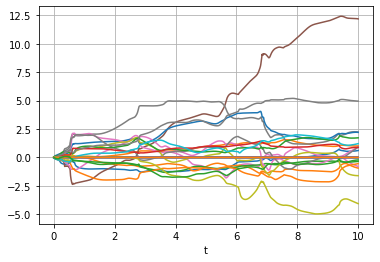

In [25]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [26]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [27]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [28]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [29]:
psi = var_ansatz(start_point,psi_0)

In [30]:
expt_value_u = np.zeros(len(time_domain))
expt_value_v = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)



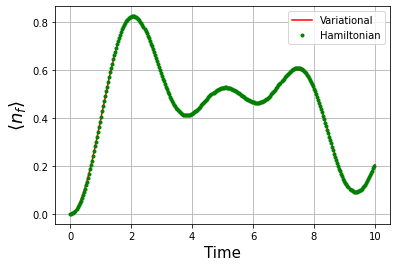

In [33]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")
plt.plot(time_domain[::10],expt_value_v[::10],".",color = "green",label = "Hamiltonian")

plt.ylabel(r"$\langle n_f\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
